In [1]:
# importing neccessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
import spacy
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow
import keras
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# from gensim.models import Word2Vec

In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mohan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Reading the dataset
data = pd.read_csv('Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
data.shape

(14640, 15)

In [5]:
data.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [6]:
data.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [7]:
data['text'][9]

"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."

In [8]:
#sentiment count
data['airline_sentiment'].value_counts()            # Dataset is Unbalanced 

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

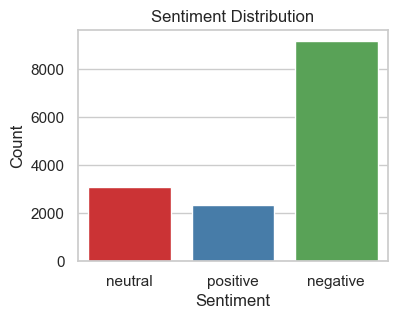

In [9]:
#Distribution of sentiment
sns.set(style="whitegrid")
plt.figure(figsize=(4, 3))
sns.countplot(data=data, x='airline_sentiment', palette='Set1')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

# Show the plot
plt.show()

In [10]:
# Checking for duplicate values
data.duplicated().sum()                    # No duplicate values present

36

In [11]:
data.loc[data.duplicated(),:]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
12040,570308309682675712,negative,1.0,Customer Service Issue,1.0,American,NaN,SweeLoTmac,NaN,0,@AmericanAir why would I even consider continu...,NaN,2015-02-24 11:44:31 -0800,NaN,Quito
12059,570305051819941889,neutral,1.0,NaN,NaN,American,NaN,Chandrafaythe,NaN,0,@AmericanAir my flight got Cancelled Flightled...,NaN,2015-02-24 11:31:34 -0800,NaN,Quito
12063,570303383782989824,neutral,1.0,NaN,NaN,American,NaN,trentgillaspie,NaN,0,.@AmericanAir just disappointed with the Fligh...,NaN,2015-02-24 11:24:57 -0800,"Austin, but often Denver",Mountain Time (US & Canada)
12066,570301929580048385,neutral,1.0,NaN,NaN,American,NaN,FinEdChat,NaN,0,@AmericanAir I did,NaN,2015-02-24 11:19:10 -0800,"Cincinnati, Ohio",Atlantic Time (Canada)
12068,570301395141836801,negative,1.0,Late Flight,1.0,American,NaN,JoBarredaV,NaN,1,@AmericanAir r u serious?? 304min #delay with ...,NaN,2015-02-24 11:17:02 -0800,Mexico City,Central Time (US & Canada)
12069,570300915418320897,negative,1.0,Cancelled Flight,1.0,American,NaN,LancasterPattie,NaN,0,@AmericanAir You are jumping the gun and Cance...,NaN,2015-02-24 11:15:08 -0800,NaN,NaN
12074,570299252141903873,positive,1.0,NaN,NaN,American,NaN,Mtts28,NaN,0,@AmericanAir This is exactly why ill be flying...,NaN,2015-02-24 11:08:32 -0800,Virginia,Eastern Time (US & Canada)
12075,570298770136674304,negative,1.0,Customer Service Issue,1.0,American,NaN,law_econ,NaN,0,@AmericanAir This doesn't address my issue. I ...,NaN,2015-02-24 11:06:37 -0800,"Newport Beach, CA",Central Time (US & Canada)
12078,570298644475346945,negative,1.0,Customer Service Issue,1.0,American,NaN,denismishin,NaN,0,@AmericanAir submitted a case to AA customer r...,NaN,2015-02-24 11:06:07 -0800,"Bellevue, WA",Eastern Time (US & Canada)
12079,570298371140939776,negative,1.0,Late Flight,1.0,American,NaN,djjohnpayne,NaN,0,@AmericanAir if by near the gate you mean sitt...,"[0.0, 0.0]",2015-02-24 11:05:01 -0800,"Las Vegas, NV",Pacific Time (US & Canada)


In [12]:
#drop the duplicate values
data.drop_duplicates(inplace=True)

## Basic Preprocessing
- Removing tags
- lowercasing
- removing punctuations
- removing stopwords
- lemmatization

#### Removing HTML tags

In [13]:
import re
def remove_tags(raw_text):
    cleaned_text = re.sub(re.compile('<.*?>'), '', raw_text)
    return cleaned_text

data['text'] = data['text'].apply(remove_tags)

In [14]:
data['text'][9]

"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."

#### Lowercasing

In [15]:
data['text'] = data['text'].apply(lambda x:x.lower())

#### Removing Punctuations

In [16]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


data['text'] = data['text'].apply(lambda text: remove_punctuation(text))

#### Removing stopwords

In [17]:
from nltk.corpus import stopwords

sw_list = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: [item for item in x.split() if item not in sw_list]).apply(lambda x:" ".join(x))

In [18]:
data['text'][9]

'virginamerica amazing arrived hour early youre good'

In [19]:
data.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,virginamerica dhepburn said,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,virginamerica plus youve added commercials exp...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,virginamerica didnt today must mean need take ...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,virginamerica really aggressive blast obnoxiou...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,virginamerica really big bad thing,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


#### Lemmatization

In [20]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

data['text'] = data['text'].apply(lambda text: lemmatize_words(text))
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,virginamerica dhepburn said,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,virginamerica plus youve added commercial expe...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,virginamerica didnt today must mean need take ...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,virginamerica really aggressive blast obnoxiou...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,virginamerica really big bad thing,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Feature Extraction Techniques:
- BOW
- TF-IDF
- Word2Vec

In [21]:
# x = data['text']
x = data.iloc[:,10:11]
x.head()

,text
0,virginamerica dhepburn said
1,virginamerica plus youve added commercial expe...
2,virginamerica didnt today must mean need take ...
3,virginamerica really aggressive blast obnoxiou...
4,virginamerica really big bad thing


In [22]:
y = data['airline_sentiment']
y.head()

0     neutral
1    positive
2     neutral
3    negative
4    negative
Name: airline_sentiment, dtype: object

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=134)

In [24]:
x_train

,text
561,united email addressusername signon available
6372,southwestair im trying get home nashville ive ...
205,virginamerica goodness people love field amazi...
9980,usairways united say luggage hold almost 35 hr...
8648,jetblue missing point flight left hour late fl...
...,...
12438,americanair absolute worst experience ever
13723,americanair service received u rude well expec...
11640,usairways wheres bag called noon promising tod...
13898,americanair aa45 jfk la


### BOW

Bags of words model : It is used to convert text documents to numerical vectors or bag of words.

In [25]:
cv = CountVectorizer(stop_words = "english", min_df = 10, max_df=200, max_features = 2000)

In [26]:
#parse matrix to numpy array to_array
x_train_bow = cv.fit_transform(x_train['text']).toarray()
x_test_bow = cv.transform(x_test['text']).toarray()

In [27]:
len(cv.vocabulary_)

1280

### TF-IDF

Term Frequency-Inverse Document Frequency model (TFIDF) : It is used to convert text documents to matrix of tfidf features.

In [28]:
tfidfvec = TfidfVectorizer(stop_words = "english", min_df = 10, max_df=200, max_features = 2000)

In [29]:
#parse matrix to numpy array to_array
x_train_tfidf= tfidfvec.fit_transform(x_train['text']).toarray()
x_test_tfidf = tfidfvec.transform(x_test['text']).toarray()

In [30]:
len(tfidfvec.vocabulary_)

1280

### Word2Vec

In [31]:
import gensim
from nltk import sent_tokenize
from gensim.utils import simple_preprocess

In [32]:
story = []
for doc in data['text']: #We sentence tokenize our doc then do preprocessing
    raw_sent = sent_tokenize(doc)
    for sent in raw_sent:
        story.append(simple_preprocess(sent))

In [33]:
#Model building            by default dimension is 100 in gensim
model = gensim.models.Word2Vec(
    window=10,
    min_count=2
)

In [34]:
#building vocabulary
model.build_vocab(story)

In [35]:
#training our model (trained word2vec model)
model.train(story, total_examples=model.corpus_count, epochs=model.epochs)

(577150, 730920)

In [36]:
len(model.wv.index_to_key)   #no.of words in our vocabulary

5482

In [37]:
#we created vector for our words, now we will create vector to represent our reviews
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis=0)

In [38]:
document_vector(data['text'].values[0])     #converted reviews to vector with 100 dimension

array([ 0.22273943, -0.03555826, -0.2710609 , -0.33250916,  0.28576398,
       -0.8215915 ,  0.11118385,  1.0096145 ,  0.29170793, -0.48982412,
        0.28932434, -0.3513648 , -0.38972908,  0.27210933,  0.29232207,
        0.2554202 , -0.3063162 , -0.7150808 ,  0.20202656, -1.1321454 ,
        0.010397  ,  0.08812815,  0.40413433, -0.6373466 , -0.01781482,
        0.06822874, -0.21541426, -0.02626099, -0.21660016,  0.1905432 ,
        0.45760366, -0.1254714 ,  0.70420754, -0.22456792,  0.2954603 ,
        0.25812846, -0.17381984, -0.81261504,  0.24888381, -0.6637374 ,
        0.02714721, -0.7137165 , -0.6014303 , -0.3515762 ,  0.74052715,
       -0.4287758 , -0.10836396, -0.14192808,  0.19167793,  0.60962176,
       -0.04582207, -0.7039459 , -0.05879759,  0.3932609 ,  0.15485609,
        0.25998378,  0.49568728,  0.15661812, -0.60040337,  0.6123358 ,
       -0.31455863,  0.25501683, -0.08887517,  0.16598283, -0.67832035,
        0.51891685,  0.45534873,  0.44432288, -0.8989862 ,  0.72

In [39]:
from tqdm import tqdm
X = []
for doc in tqdm(data['text'].values):
    X.append(document_vector(doc))

100%|██████████| 14604/14604 [00:06<00:00, 2242.77it/s]


In [40]:
X = np.array(X)

In [41]:
X.shape

(14604, 100)

In [42]:
Y = data['airline_sentiment']

In [43]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=1)

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [45]:
rf = RandomForestClassifier()
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)
accuracy_score(Y_test,Y_pred)

0.7038685381718589

## Model Building and Evaluation

## 1. GaussianNB

In [46]:
## Using BOW

In [47]:
#Gaussian Naive Bayes algorithm
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb.fit(x_train_bow,y_train)

GaussianNB()

In [48]:
y_pred = gnb.predict(x_test_bow)

from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(y_test,y_pred)

0.3515919205751455

In [49]:
## Using TF-IDF

In [50]:
gnb = GaussianNB()

gnb.fit(x_train_tfidf,y_train)

GaussianNB()

In [51]:
y_pred = gnb.predict(x_test_tfidf)

accuracy_score(y_test,y_pred)

0.3642588154741527

## 2. RandomForestClassifier

In [52]:
## Using BOW

In [53]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

rf.fit(x_train_bow,y_train)
y_pred = rf.predict(x_test_bow)
accuracy_score(y_test,y_pred)

0.6713454296473811

In [54]:
## Using TF-IDF

In [55]:
rf = RandomForestClassifier()

rf.fit(x_train_tfidf,y_train)
y_pred = rf.predict(x_test_tfidf)
accuracy_score(y_test,y_pred)

0.6977062649777473

- Best performing one is Random Forest model with TF-IDF feature extraction technique

Now, we will try increasing no.of features

In [56]:
## With max features = 20000

In [57]:
cv = CountVectorizer(max_features=20000)

x_train_bow = cv.fit_transform(x_train['text']).toarray()
x_test_bow = cv.transform(x_test['text']).toarray()


rf = RandomForestClassifier()

rf.fit(x_train_bow,y_train)
y_pred = rf.predict(x_test_bow)
accuracy_score(y_test,y_pred)

0.7562478603218076

In [61]:
tfidfvec = TfidfVectorizer(max_features=20000)

x_train_tfidf = tfidfvec.fit_transform(x_train['text']).toarray()
x_test_tfidf = tfidfvec.transform(x_test['text']).toarray()

rf = RandomForestClassifier()

rf.fit(x_train_tfidf,y_train)
y_pred = rf.predict(x_test_tfidf)
accuracy_score(y_test,y_pred)

0.7648065730914071

In [62]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report

In [63]:
print('The accuracy score is: ', accuracy_score(y_test,y_pred))

The accuracy score is:  0.7648065730914071


In [64]:
recall_score(y_test,y_pred,average='macro')

0.6377781018407914

In [65]:
f1_score(y_test,y_pred,average='macro')

0.6688542978474344

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

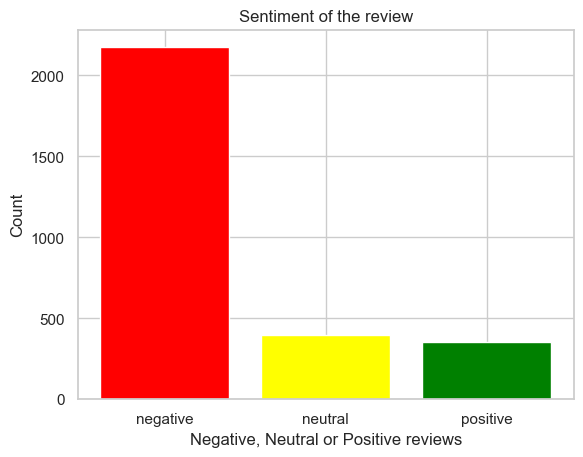

In [67]:
# Calculate the counts of 0s and 1s and 2s
unique, counts = np.unique(y_pred, return_counts=True)
counts_dict = dict(zip(unique, counts))
# Define colors for each class
colors = ['red', 'yellow', 'green']

# Create a bar graph
plt.bar(counts_dict.keys(), counts_dict.values(), color=colors)
plt.xlabel('Negative, Neutral or Positive reviews')
plt.ylabel('Count')
plt.xticks(list(counts_dict.keys()))
plt.title('Sentiment of the review')
plt.show()

# Conclusion:
#### with max features as 20000, we got accuracy for RandomForest model as 76% while using TF-IDF feature extraction Technique

## RNN

In [68]:
texts = data['text'].values
labels = data['airline_sentiment'].values

In [69]:
# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

In [70]:
labels

array([1, 2, 1, ..., 1, 0, 1])

In [71]:
# Tokenize the text data
max_words = 10000          # We can adjust this based on our vocabulary size
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [72]:
# Pad sequences to a fixed length
max_sequence_length = 200   # We can adjust this based on our sequence length
data = pad_sequences(sequences, maxlen=max_sequence_length)

Epoch 1/20
366/366 [==============================] - 28s 70ms/step - loss: 0.7494 - accuracy: 0.6843 - val_loss: 0.5860 - val_accuracy: 0.7720
Epoch 2/20
366/366 [==============================] - 24s 65ms/step - loss: 0.6211 - accuracy: 0.7492 - val_loss: 0.6114 - val_accuracy: 0.7562
Epoch 3/20
366/366 [==============================] - 25s 67ms/step - loss: 0.4248 - accuracy: 0.8382 - val_loss: 0.5992 - val_accuracy: 0.7761
Epoch 4/20
366/366 [==============================] - 24s 65ms/step - loss: 0.2575 - accuracy: 0.9074 - val_loss: 0.6861 - val_accuracy: 0.7593
Epoch 5/20
366/366 [==============================] - 24s 65ms/step - loss: 0.1505 - accuracy: 0.9492 - val_loss: 0.8082 - val_accuracy: 0.7576
Epoch 6/20
92/92 [==============================] - 2s 24ms/step - loss: 0.5860 - accuracy: 0.7720
Test loss: 0.5860
Test accuracy: 0.7720


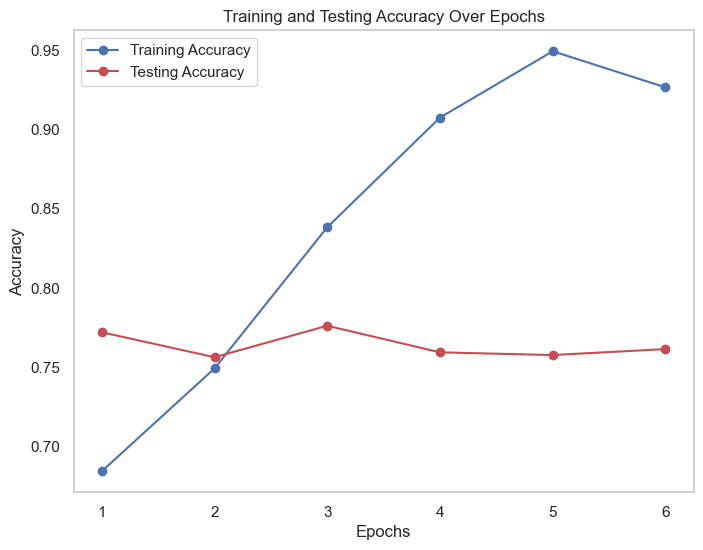

In [73]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify = labels)

# Create the RNN model
model = Sequential()

# Add an embedding layer
embedding_dim = 100  # Adjust as needed
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))

# Add a SimpleRNN layer with dropout
model.add(SimpleRNN(128, activation='tanh', return_sequences=False))
model.add(Dropout(0.5))  # Dropout layer to reduce overfitting

# Add a Dense layer with one output unit (for binary sentiment classification)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Extract accuracy data from the training history
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Create a plot to visualize the training and testing accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', marker='o', linestyle='-', color='b')
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, label='Testing Accuracy', marker='o', linestyle='-', color='r')

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend(loc='best')

# Show the plot
plt.grid()
plt.show()


-  Our RNN model is making progress in terms of accuracy, but it's facing some challenges in later epochs. 

In [74]:
prediction = model.predict(X_test)

92/92 [==============================] - 2s 23ms/step


In [75]:
prediction

array([[0.85361487, 0.12011133, 0.02627377],
       [0.7346979 , 0.18841396, 0.07688818],
       [0.54517245, 0.36923307, 0.08559445],
       ...,
       [0.9669926 , 0.02972989, 0.00327751],
       [0.91399413, 0.07597411, 0.01003174],
       [0.8779274 , 0.09948126, 0.02259124]], dtype=float32)

In [76]:
# Reviews on which we need to predict
sentence = ["virginamerica amazing arrived hour early youre good"]

# Convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# Pad the sequence
max_length = 200  # Make sure this matches the max_sequence_length used during training
padded = pad_sequences(sequences, padding='post', maxlen=max_length)

# Get labels based on the predicted class with the highest probability
prediction = model.predict(padded)
pred_labels = np.argmax(prediction, axis=1)

# Map numerical labels to sentiment categories
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
for i in range(len(sentence)):
    print(sentence[i])
    predicted_sentiment = sentiment_mapping[pred_labels[i]]
    print("Predicted sentiment: ", predicted_sentiment)

1/1 [==============================] - 0s 59ms/step
virginamerica amazing arrived hour early youre good
Predicted sentiment:  Neutral


In [77]:
# Reviews on which we need to predict
sentence = [ "@VirginAmerica I have an unused ticket but moved to a new city where you don't fly. How can I fly with you before it expires? #travelhelp"]

# Convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# Pad the sequence
max_length = 200  # Make sure this matches the max_sequence_length used during training
padded = pad_sequences(sequences, padding='post', maxlen=max_length)

# Get labels based on the predicted class with the highest probability
prediction = model.predict(padded)
pred_labels = np.argmax(prediction, axis=1)

# Map numerical labels to sentiment categories
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
for i in range(len(sentence)):
    print(sentence[i])
    predicted_sentiment = sentiment_mapping[pred_labels[i]]
    print("Predicted sentiment: ", predicted_sentiment)

1/1 [==============================] - 0s 60ms/step
@VirginAmerica I have an unused ticket but moved to a new city where you don't fly. How can I fly with you before it expires? #travelhelp
Predicted sentiment:  Neutral


In [78]:
# Get the predicted probabilities for each class
predicted_probabilities = model.predict(padded)

# Print the predicted probabilities for each class
for i, prob in enumerate(predicted_probabilities[0]):
    sentiment = sentiment_mapping[i]
    print(f"Probability of {sentiment}: {prob:.4f}")

1/1 [==============================] - 0s 50ms/step
Probability of Negative: 0.3022
Probability of Neutral: 0.4411
Probability of Positive: 0.2568


# LSTM

In [79]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint   

In [80]:
# Create the RNN model
model = Sequential()

# Add an embedding layer
embedding_dim = 100  # Adjust as needed
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))

# Add an LSTM layer with dropout
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.5))  # Dropout layer to reduce overfitting

# Add a Dense layer with one output unit (for binary sentiment classification)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Implement learning rate schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

In [81]:
#Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/20
366/366 [==============================] - 51s 131ms/step - loss: 0.6845 - accuracy: 0.7259 - val_loss: 0.5479 - val_accuracy: 0.7912 - lr: 0.0010
Epoch 2/20
366/366 [==============================] - 48s 130ms/step - loss: 0.4254 - accuracy: 0.8364 - val_loss: 0.5378 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 3/20
366/366 [==============================] - 47s 129ms/step - loss: 0.2993 - accuracy: 0.8922 - val_loss: 0.6032 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 4/20
366/366 [==============================] - 47s 130ms/step - loss: 0.2225 - accuracy: 0.9224 - val_loss: 0.7364 - val_accuracy: 0.7686 - lr: 0.0010
Epoch 5/20
366/366 [==============================] - 47s 129ms/step - loss: 0.1691 - accuracy: 0.9414 - val_loss: 0.8363 - val_accuracy: 0.7706 - lr: 0.0010
Epoch 6/20
366/366 [==============================] - 47s 129ms/step - loss: 0.1047 - accuracy: 0.9658 - val_loss: 0.9207 - val_accuracy: 0.7645 - lr: 2.0000e-04
Epoch 7/20
366/366 [============================

In [82]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

92/92 [==============================] - 4s 44ms/step - loss: 0.5378 - accuracy: 0.7919
Test loss: 0.5378
Test accuracy: 0.7919


In [83]:
# Extract accuracy data from the training history
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

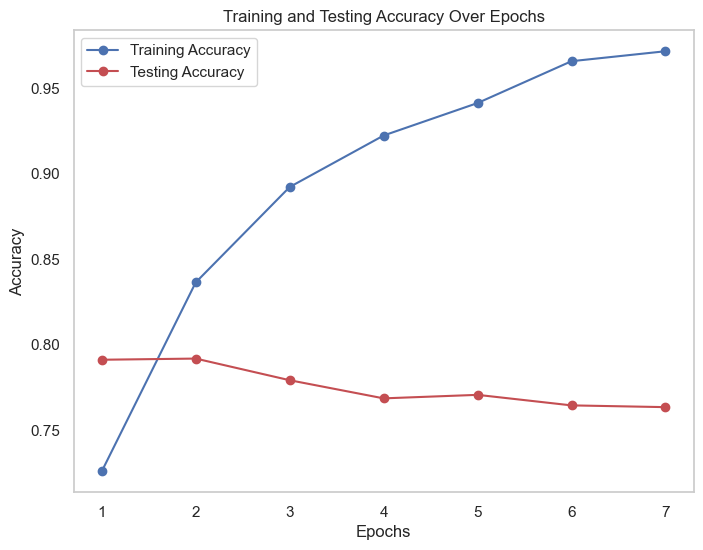

In [84]:
# Create a plot to visualize the training and testing accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', marker='o', linestyle='-', color='b')
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, label='Testing Accuracy', marker='o', linestyle='-', color='r')

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend(loc='best')

# Show the plot
plt.grid()
plt.show()

In [85]:
# Reviews on which we need to predict
sentence = ["'virginamerica amazing arrived hour early youre good'"]

# Convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# Pad the sequence
max_length = 200  # Make sure this matches the max_sequence_length used during training
padded = pad_sequences(sequences, padding='post', maxlen=max_length)

# Get labels based on the predicted class with the highest probability
prediction = model.predict(padded)
pred_labels = np.argmax(prediction, axis=1)

# Map numerical labels to sentiment categories
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
for i in range(len(sentence)):
    print(sentence[i])
    predicted_sentiment = sentiment_mapping[pred_labels[i]]
    print("Predicted sentiment: ", predicted_sentiment)

1/1 [==============================] - 1s 615ms/step
'virginamerica amazing arrived hour early youre good'
Predicted sentiment:  Neutral


In [86]:
# Get the predicted probabilities for each class
predicted_probabilities = model.predict(padded)

# Print the predicted probabilities for each class
for i, prob in enumerate(predicted_probabilities[0]):
    sentiment = sentiment_mapping[i]
    print(f"Probability of {sentiment}: {prob:.4f}")

1/1 [==============================] - 0s 56ms/step
Probability of Negative: 0.2100
Probability of Neutral: 0.5779
Probability of Positive: 0.2121


In [87]:
prediction[0][0]

0.21000905

In [88]:
prediction

array([[0.21000905, 0.57787144, 0.21211949]], dtype=float32)

In [89]:
pred_labels

array([1], dtype=int64)

In [90]:
# Hyperparameters of the model
vocab_size = 17500 
oov_tok = ''
embedding_dim = 100
max_length = 200 
padding_type='post'
trunc_type='post'

# CNN

In [91]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

Epoch 1/20
366/366 [==============================] - 17s 43ms/step - loss: 0.6969 - accuracy: 0.7151 - val_loss: 0.5539 - val_accuracy: 0.7860
Epoch 2/20
366/366 [==============================] - 15s 42ms/step - loss: 0.4462 - accuracy: 0.8297 - val_loss: 0.5385 - val_accuracy: 0.7850
Epoch 3/20
366/366 [==============================] - 16s 43ms/step - loss: 0.2815 - accuracy: 0.9030 - val_loss: 0.6179 - val_accuracy: 0.7819
Epoch 4/20
366/366 [==============================] - 15s 41ms/step - loss: 0.1670 - accuracy: 0.9469 - val_loss: 0.7587 - val_accuracy: 0.7764
Epoch 5/20
366/366 [==============================] - 15s 42ms/step - loss: 0.0997 - accuracy: 0.9699 - val_loss: 0.8794 - val_accuracy: 0.7628
Epoch 6/20
366/366 [==============================] - 15s 42ms/step - loss: 0.0674 - accuracy: 0.9807 - val_loss: 1.0230 - val_accuracy: 0.7713
Epoch 7/20
92/92 [==============================] - 1s 12ms/step - loss: 0.5385 - accuracy: 0.7850
Test loss: 0.5385
Test accuracy: 0.78

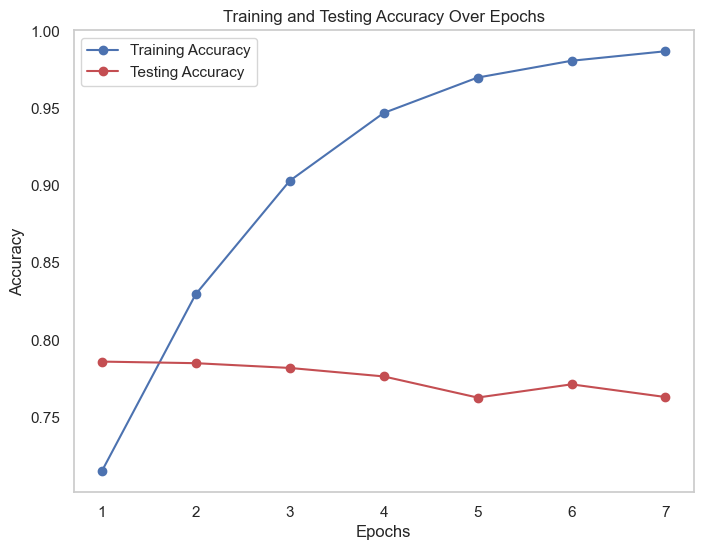

In [92]:
# Create the CNN model
embedding_dim = 100
filters = 128
kernel_size = 5

model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))

# Add a 1D convolutional layer
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())

# Add a Dense layer with dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Add the output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Extract accuracy data from the training history
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Create a plot to visualize the training and testing accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', marker='o', linestyle='-', color='b')
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, label='Testing Accuracy', marker='o', linestyle='-', color='r')

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend(loc='best')

# Show the plot
plt.grid()
plt.show()


In [93]:
# Reviews on which we need to predict
sentence = ["'virginamerica is amazing arrived hour early you are so good'"]

# Convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# Pad the sequence
max_length = 200  # Make sure this matches the max_sequence_length used during training
padded = pad_sequences(sequences, padding='post', maxlen=max_length)

# Get labels based on the predicted class with the highest probability
prediction = model.predict(padded)
pred_labels = np.argmax(prediction, axis=1)

# Map numerical labels to sentiment categories
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
for i in range(len(sentence)):
    print(sentence[i])
    predicted_sentiment = sentiment_mapping[pred_labels[i]]
    print("Predicted sentiment: ", predicted_sentiment)

1/1 [==============================] - 0s 125ms/step
'virginamerica is amazing arrived hour early you are so good'
Predicted sentiment:  Negative


In [94]:
# Get the predicted probabilities for each class
predicted_probabilities = model.predict(padded)

# Print the predicted probabilities for each class
for i, prob in enumerate(predicted_probabilities[0]):
    sentiment = sentiment_mapping[i]
    print(f"Probability of {sentiment}: {prob:.4f}")

1/1 [==============================] - 0s 43ms/step
Probability of Negative: 0.9513
Probability of Neutral: 0.0364
Probability of Positive: 0.0122


###### CNN model appears to be the most promising, given its high accuracy and reasonable generalization. But it is prone to overfitting. For Streamlit app, let's take LSTM model. RNN model has lower accuracy on both training and validation data.

In [89]:
import pickle

#For model
pickle.dump(model,open('lstm_model.pkl','wb'))

In [90]:
model.save("lstm_model")

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


In [91]:
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)